In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh
from fusiondls import run_dls, file_read, file_write
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach



onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *

from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read balance file

In [2]:
balance_paths = dict(
    SPR45 = r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-09-09 - STEP simulation for wide radiation front",
    V10 = r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-09-12 - Ryoko V10\step0_A5e21spr",
    # DTT = r"C:\Users\mikek\OneDrive\Project\DLS\from_matteo\2024-09-13 - DTT cases\20230906.Ne_1e20.SOLEDGE2D.Pump_0.9875")
)


In [3]:
eqb = dict()

for case in balance_paths:
    eqb[case] = dict()
    for side in ["ol", "il"]:
        eqb[case][side] = dict()
        for i in range(10):
            eqb[case][side][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = side, sepadd=i, 
                resolution = 500, diagnostic_plot = False, refine_xpoint = False)
    
        
# file_write(eqb, "equilibrium.pkl")

# Read SOLPS case

In [4]:
store_slc = {}

for case in balance_paths:
    store_slc[case] = SOLPScase(balance_paths[case])
    store_slc[case].get_species()
    store_slc[case].get_impurity_stats("Ar", all_states = True)

Saving all states
Added total radiation, density and fraction for Ar
Saving all states
Added total radiation, density and fraction for Ar


# Compare geometry
- It's not quite the same. 
- It's possible that this is because in DLS we interpolate between the points, and small differences add up

In [231]:
%matplotlib inline

## Outer

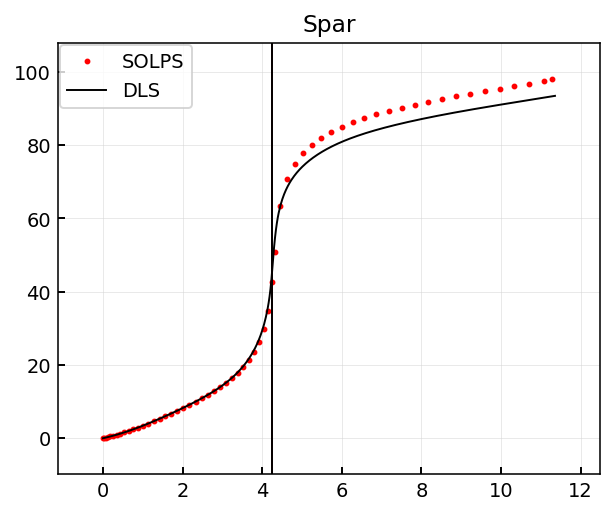

In [240]:
sepadd = 1
d = eqb["SPR45"]["ol"][sepadd].copy()
slc = store_slc["SPR45"]

df = slc.get_1d_poloidal_data(["Btot", "Bpol", "R", "Z"], sepadd = sepadd)
df["Spol"] = df["Spol"].iloc[-1] - df["Spol"]
df["Spar"] = df["Spar"].iloc[-1] - df["Spar"]
df["Bpol"] = abs(df["Bpol"])

style_dls = dict(lw = 1, alpha = 1, c ="k")
style_solps = dict(marker = "o", ms = 2, lw = 0, c = "r")

# for param in ["R", "Z", "Bpol", "Btot", "Spar"]:
for param in ["Spar"]:
    fig, ax = plt.subplots()

    ax.plot(df["Spol"], df[param], label = "SOLPS", **style_solps)
    
    dlsparam = "S" if param == "Spar" else param
    ax.plot(d["Spol"], d[dlsparam], label = "DLS", **style_dls)
    
    ylim = ax.get_ylim()
    ax.vlines(df[df["Xpoint"]==1]["Spol"], *ylim, color = "r", lw = 1)
    ax.vlines(d["Spol"][d["Xpoint"]], *ylim, color = "k", lw = 1)
    ax.set_ylim(ylim)
    ax.set_title(param)
    ax.legend()

## Inner

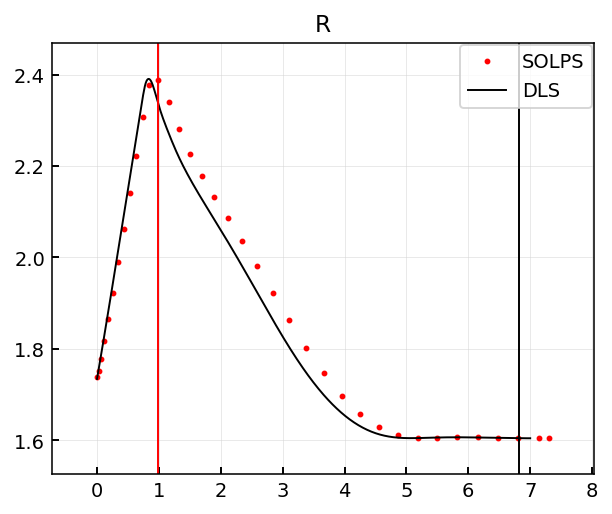

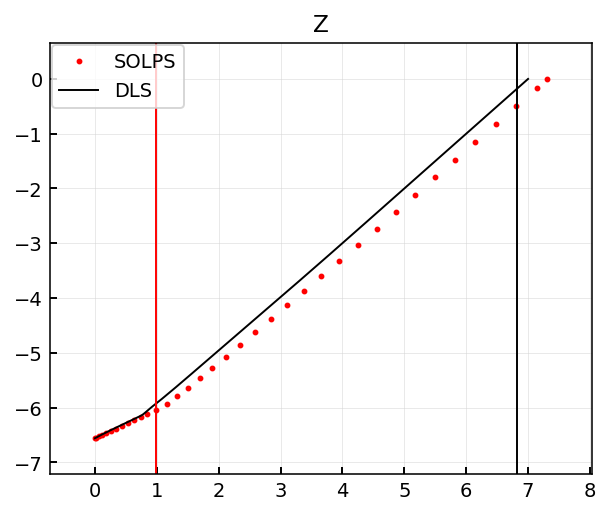

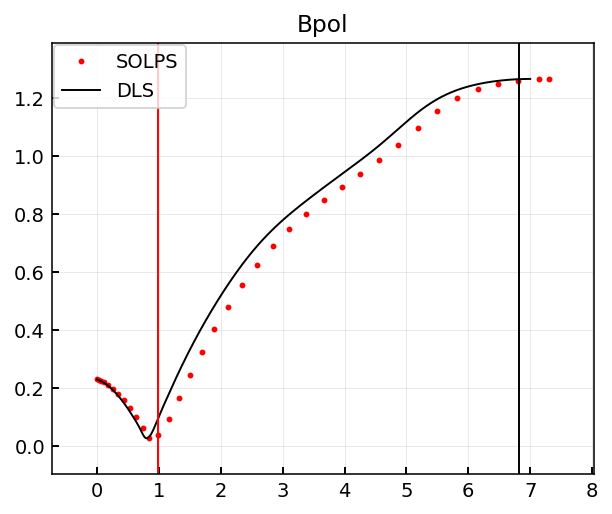

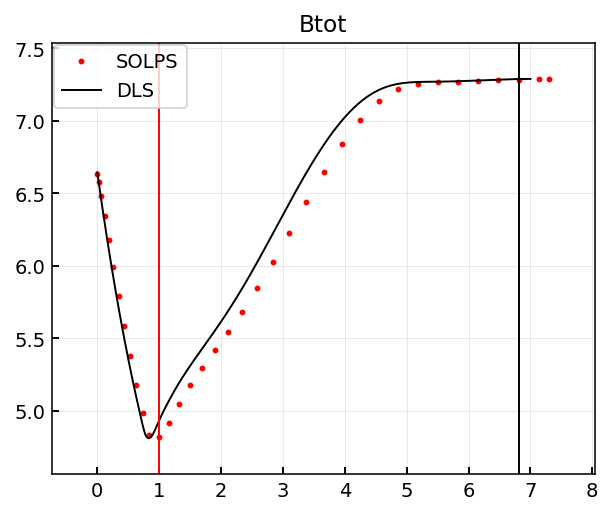

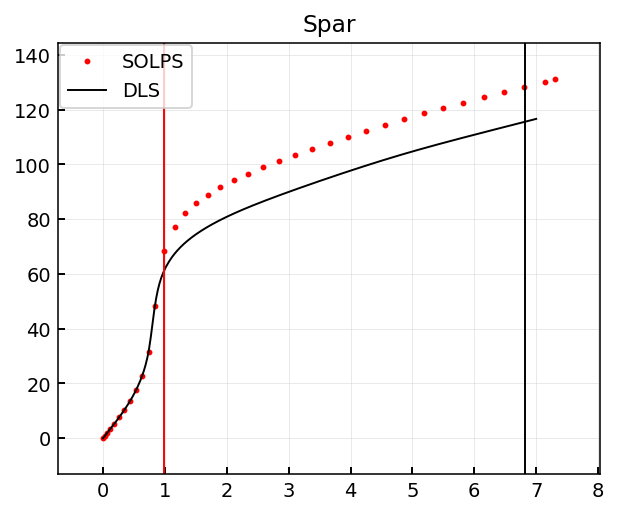

In [15]:
sepadd = 1
d = eqb["SPR45"]["il"][sepadd].copy()
slc = store_slc["SPR45"]

df = slc.get_1d_poloidal_data(["Btot", "Bpol", "R", "Z"], region = "inner_lower", sepadd = sepadd)
df["Spol"] = df["Spol"].iloc[-1] - df["Spol"]
df["Spar"] = df["Spar"].iloc[-1] - df["Spar"]
df["Bpol"] = abs(df["Bpol"])

style_dls = dict(lw = 1, alpha = 1, c ="k")
style_solps = dict(marker = "o", ms = 2, lw = 0, c = "r")

for param in ["R", "Z", "Bpol", "Btot", "Spar"]:
# for param in ["Spar"]:
    fig, ax = plt.subplots()

    ax.plot(df["Spol"], df[param], label = "SOLPS", **style_solps)
    
    dlsparam = "S" if param == "Spar" else param
    ax.plot(d["Spol"], d[dlsparam], label = "DLS", **style_dls)
    
    ylim = ax.get_ylim()
    ax.vlines(df[df["Xpoint"]==1]["Spol"], *ylim, color = "r", lw = 1)
    ax.vlines(d["Spol"][d["Xpoint"]], *ylim, color = "k", lw = 1)
    ax.set_ylim(ylim)
    ax.set_title(param)
    ax.legend()

In [193]:
dls_geom.keys()

dict_keys(['R', 'Z', 'Xpoint', 'R_leg', 'Z_leg', 'Btot', 'Bpol', 'S', 'Spol', 'name', 'full_R', 'full_Z'])

In [209]:
sepadd = 1
dls_geom = unpackConfigurationMK(File = os.path.join(balance_paths["SPR45"], "balance.nc"), Type = "il", 
                          sepadd=sepadd, resolution = 100, diagnostic_plot = False,
                          refine_xpoint = True)

dls = pd.DataFrame()
for key in ["R", "Z", "Btot", "Bpol", "S", "Spol"]:
    dls[key] = dls_geom[key]
    
Xpoint_idx = dls_geom["Xpoint"]
dls.loc[Xpoint_idx, "Xpoint"] = 1
dls["Spar"] = dls.pop("S")

dls.loc[Xpoint_idx:, "region"] = "SOL"
dls.loc[:Xpoint_idx, "region"] = "divertor"

dls

,R,Z,Btot,Bpol,Spol,Xpoint,Spar,region
0,1.734517,-6.559103e+00,6.645598,0.229995,0.000000,NaN,0.000000,divertor
1,1.790958,-6.516564e+00,6.436181,0.223258,0.070676,NaN,2.037479,divertor
2,1.848541,-6.475581e+00,6.235426,0.214081,0.141354,NaN,4.096085,divertor
3,1.906913,-6.435727e+00,6.044037,0.202150,0.212033,NaN,6.209305,divertor
4,1.965835,-6.396699e+00,5.861978,0.187549,0.282710,NaN,8.418340,divertor
...,...,...,...,...,...,...,...,...
95,1.604996,-2.827152e-01,7.288172,1.264783,6.715565,NaN,114.035983,SOL
96,1.604890,-2.120366e-01,7.288785,1.265631,6.786243,NaN,114.443023,SOL
97,1.604811,-1.413579e-01,7.289240,1.266233,6.856922,NaN,114.849894,SOL
98,1.604760,-7.067918e-02,7.289525,1.266593,6.927601,NaN,115.256666,SOL


In [259]:
%matplotlib widget

# Attempt interpolation

Text(0.5, 0, 'Bpol')

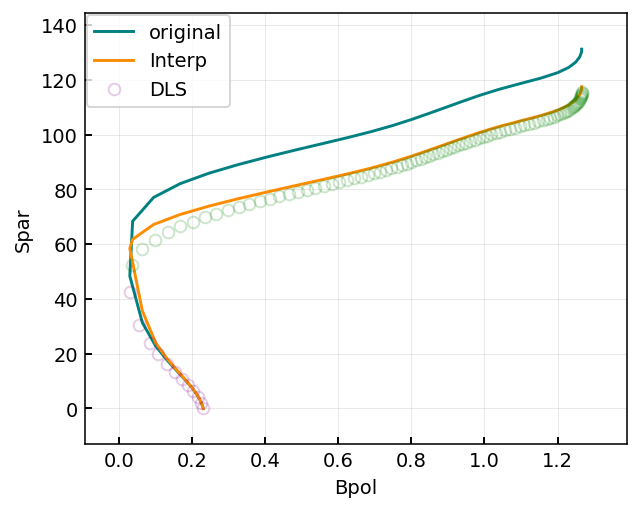

In [281]:
plt.close("all")
slc = store_slc["SPR45"]
df = slc.get_1d_poloidal_data(["Btot", "Bpol", "R", "Z"], 
                              region = "inner_lower", target_first = True, sepadd = sepadd)

# Divide SOLPS df into SOL and divertor to make them monotonic
df["Bpol"] = abs(df["Bpol"])
dfx = df[df["Xpoint"]==1]
Xpoint_idx = dfx.index[0]
xpoint_offset = 1  # For interpolation reasons
df.loc[Xpoint_idx+xpoint_offset:, "region"] = "SOL"
df.loc[:Xpoint_idx+xpoint_offset, "region"] = "divertor"

dfsol = df[df["region"] == "SOL"]
dfdiv = df[df["region"] == "divertor"]

dlssol = dls[dls["region"] == "SOL"]
dlsdiv = dls[dls["region"] == "divertor"]

## First interpolate Spol based on Bpol
param = "Bpol"

df.loc[df["region"] == "SOL", "Spol_new"] = scipy.interpolate.interp1d(
    dlssol[param], dlssol["Spol"], kind = "quadratic", fill_value = "extrapolate")(dfsol[param])
df.loc[df["region"] == "divertor", "Spol_new"] = scipy.interpolate.interp1d(
    dlsdiv[param], dlsdiv["Spol"], kind = "quadratic", fill_value = "extrapolate")(dfdiv[param])

## Then interpolate Spar based on Spol
df.loc[df["region"] == "SOL", "Spar_new"] = scipy.interpolate.interp1d(
    dlssol["Spol"], dlssol["Spar"], kind = "quadratic", fill_value = "extrapolate")(dfsol["Spol"])
df.loc[df["region"] == "divertor", "Spar_new"] = scipy.interpolate.interp1d(
    dlsdiv["Spol"], dlsdiv["Spar"], kind = "quadratic", fill_value = "extrapolate")(dfdiv["Spol"])

fig, ax = plt.subplots()
ax.plot(df[param], df["Spar"], label = "original")
ax.plot(df[param], df["Spar_new"],  label = "Interp")
ax.plot(dlsdiv[param], dlsdiv["Spar"], lw = 0, marker = "o", label = "DLS", c = "None", markeredgecolor = "purple", alpha = 0.2)
ax.plot(dlssol[param], dlssol["Spar"], lw = 0, marker = "o", c = "None", markeredgecolor = "green", alpha = 0.2)
ax.legend()
ax.set_ylabel(xparam)
ax.set_xlabel(param)

KeyError: 'Spar_new'

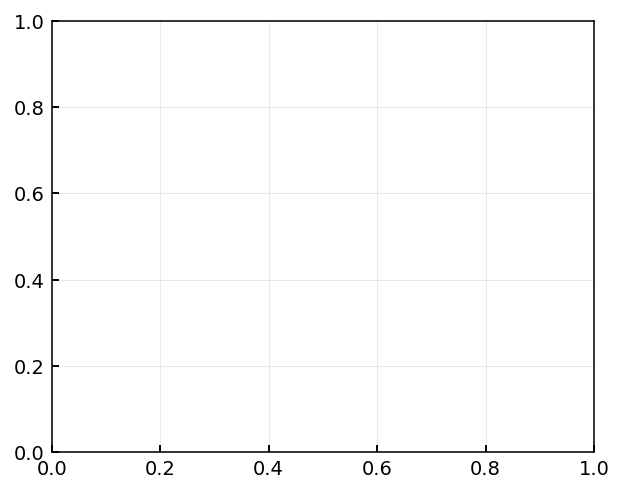

In [14]:
style_dls = dict(lw = 1, alpha = 1, c ="k")
style_solps = dict(marker = "o", ms = 2, lw = 0, c = "r")

for param in ["Spar", "Spol", "Bpol", "Btot", "R", "Z"]:
# for param in ["Spar"]:
    fig, ax = plt.subplots()
    xparam = "Spar"
    ax.plot(df[f"{xparam}_new"], df[param], label = "SOLPS", **style_solps)
    ax.plot(dls[f"{xparam}"], dls[param], label = "DLS", **style_dls)
    
    ax.set_xlabel(xparam)
    ax.set_ylabel(param)
    
    ylim = ax.get_ylim()
    ax.vlines(df[df["Xpoint"]==1][xparam], *ylim, color = "r", lw = 1)
    ax.vlines(dls[dls["Xpoint"]==1][xparam], *ylim, color = "k", lw = 1)
    ax.set_ylim(ylim)
    ax.set_title(param)
    ax.legend()

In [9]:
%matplotlib widget

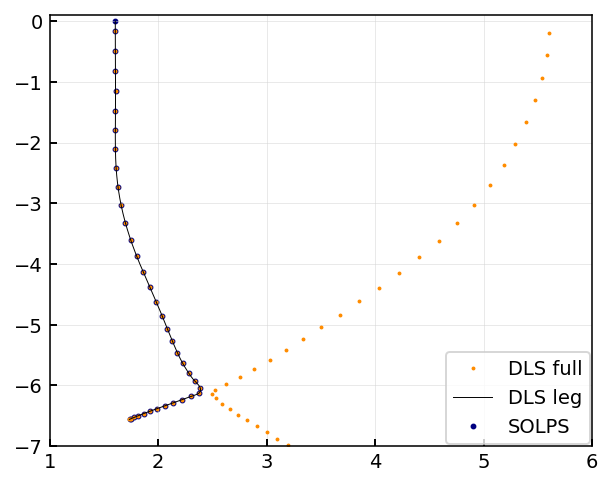

In [13]:
plt.close("all")
out = unpackConfigurationMK(File = os.path.join(balance_paths["SPR45"], "balance.nc"), Type = "il", sepadd=1, resolution = 1000, diagnostic_plot = False)
df = slc.get_1d_poloidal_data(["Btot", "Bpol", "R", "Z"], region = "inner_lower", sepadd = sepadd)

fig, ax = plt.subplots()
ax.plot(out["full_R"], out["full_Z"], c = "darkorange", marker = "o", lw = 0, ms = 1, label = "DLS full")
ax.plot(out["R"], out["Z"], c= "k", marker = "o", lw = 0.5, ms = 0, label = "DLS leg")
ax.plot(df["R"], df["Z"], c = "navy", marker = "o", ms = 2, lw = 0, label = "SOLPS", zorder = 0)
ax.set_xlim(1,6)
ax.set_ylim(-7, 0.1)
ax.legend()

In [318]:
%matplotlib inline

In [348]:
np.max(np.gradient(fullR))

2.07414766625

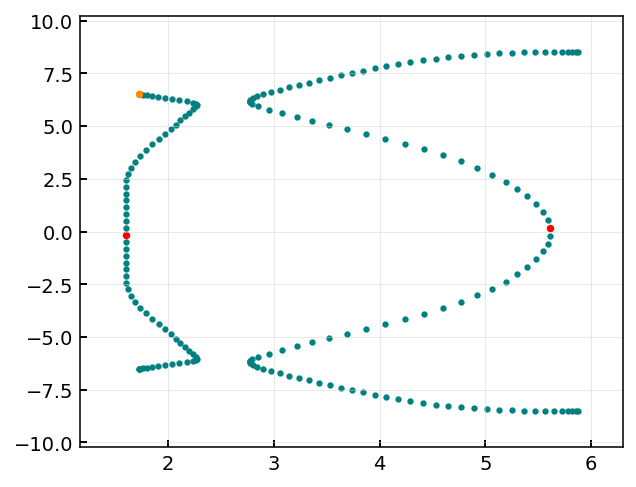

In [354]:
fullR = geom["full_R"]
fullZ = geom["full_Z"]

sign_changes = np.diff(np.sign(fullZ))
zero_crossings = np.where(sign_changes != 0)[0]
upper_break = np.argmax(np.gradient(fullR))

zero_crossings

fig, ax = plt.subplots()

ax.scatter(fullR, fullZ, s = 5)
ax.scatter(fullR[zero_crossings], fullZ[zero_crossings], c = "r", s = 8)
ax.scatter(fullR[upper_break], fullZ[upper_break], c = "darkorange", s = 8)


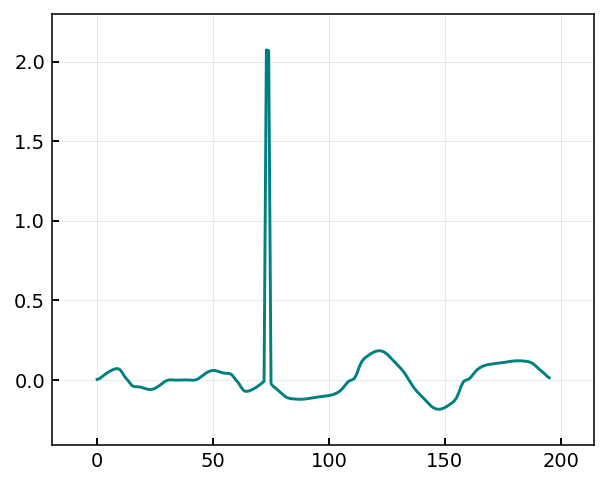

In [345]:
plt.plot()

In [331]:
geom.keys()

dict_keys(['R', 'Z', 'Xpoint', 'R_leg', 'Z_leg', 'Btot', 'Bpol', 'S', 'Spol', 'name'])

In [359]:
%matplotlib inline

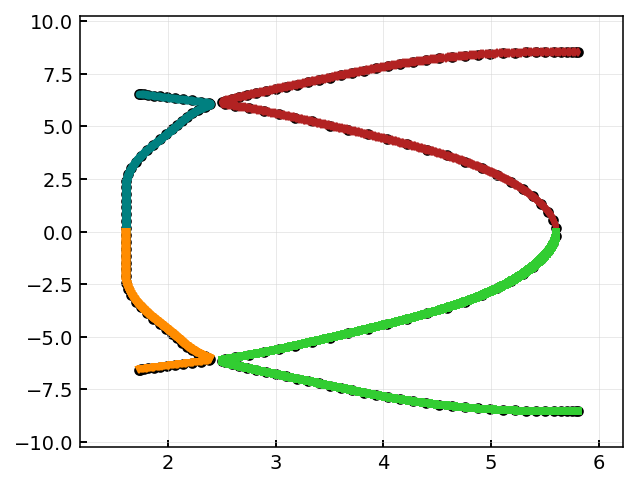

In [121]:
geom = {}
for i, side in enumerate(["iu", "il", "ou", "ol"]):
    geom[side] = unpackConfigurationMK(File = os.path.join(balance_paths[case], "balance.nc"), Type = side, sepadd=1, resolution = 500, diagnostic_plot = False)

fullR = geom["il"]["full_R"]
fullZ = geom["il"]["full_Z"]

fig, ax = plt.subplots()
ax.scatter(fullR, fullZ, s=20, c = "k")
markers = ["o", "v", "d", "s"]
for i, side in enumerate(["iu", "il", "ou", "ol"]):
    ax.plot(geom[side]["R"], geom[side]["Z"], label=side, marker = markers[i], lw = 0, ms = 3)
    
# ax.set_xlim(1,2)
# ax.set_xlim(5,6)
# ax.set_ylim(-1,1)

In [ ]:
sepadd = 1
df = slc.get_1d_poloidal_data(["Te"], sepadd = sepadd)
df

,spol,spar,Xpoint,Te
0,0.376925,0.000000,0,302.090892
1,0.753850,0.657213,0,302.059127
2,1.130397,1.315236,0,301.967106
3,1.505521,1.975854,0,301.811295
4,1.877825,2.640856,0,301.589030
...,...,...,...,...
57,11.723223,97.756028,0,0.481922
58,11.775533,97.893217,0,0.393998
59,11.816376,97.997057,0,0.303488
60,11.845275,98.068849,0,0.210917


In [121]:
def returnS(R, Z, B, Bpol):
    # return the real total distances from the target for a given configuration
    PrevR = R[0]
    s = []
    currents = 0
    PrevZ = Z[0]
    for i in range(len(R)):
        dl = np.sqrt((PrevR - R[i]) ** 2 + (PrevZ - Z[i]) ** 2)
        ds = dl * np.abs(B[i]) / np.abs(Bpol[i])
        currents += ds
        s.append(currents)
        PrevR = R[i]
        PrevZ = Z[i]
    return s

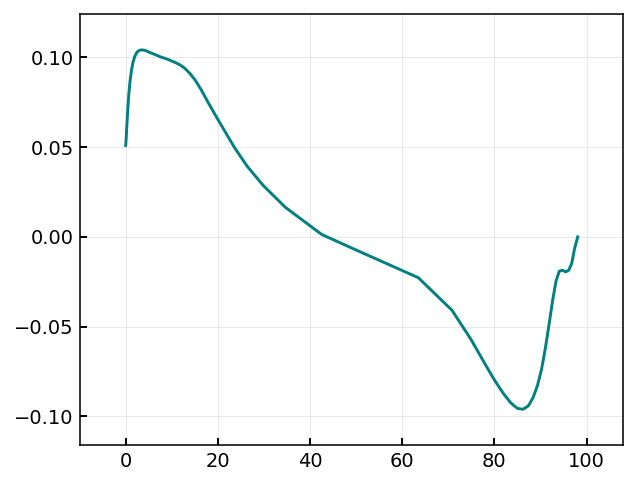

In [122]:
plt.plot(df["Spar"], np.gradient(df["Btot"], df["Spar"]))